<a href="https://colab.research.google.com/github/girijeshcse/car_finder/blob/main/notebooks/Efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import sys
import numpy as np
import pandas as pd
import decimal
from tqdm import tqdm
import glob
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
import pickle
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
BASE_PATH = '/content/drive/MyDrive/Capstone/Dataset_1/Dataset'
EDIT_PATH = '/content/drive/MyDrive/Capstone/Dataset_1'
TRAIN_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Train Images/*/*"])
TEST_IMAGES_PATH = os.path.sep.join([BASE_PATH, "Car Images/Test Images/*/*"])
TRAIN_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Train Annotations.csv"])
TEST_ANNOTS_PATH = os.path.sep.join([BASE_PATH, "Annotations/Test Annotation.csv"])
CAR_NAMES_MAKE_DICT = os.path.sep.join([BASE_PATH, "Car names and make.csv"])

In [4]:
train_annotate=pd.read_csv(TRAIN_ANNOTS_PATH)
train_annotate.rename(columns={'Image Name':'imagename','Bounding Box coordinates': 'xmin', 'Unnamed: 2': 'ymin','Unnamed: 3': 'xmax','Unnamed: 4': 'ymax'}, inplace=True)
test_annotate=pd.read_csv(TEST_ANNOTS_PATH)
test_annotate.rename(columns={'Image Name':'imagename','Bounding Box coordinates': 'xmin', 'Unnamed: 2': 'ymin','Unnamed: 3': 'xmax','Unnamed: 4': 'ymax'}, inplace=True)

In [5]:
car_map = pd.read_csv(CAR_NAMES_MAKE_DICT,names=['Cars'])
car_map = car_map.set_index('Cars')
car_map_dict=car_map.to_dict('index')
list(car_map_dict.items())[:5]
#fetch a key based on value passed - we need this to build our image paths
print(list(car_map_dict.keys())[173])

Ram C/V Cargo Van Minivan 2012


In [6]:
#reading png files in the path
trainList = glob.glob(TRAIN_IMAGES_PATH)
print(trainList)

trainListPaths = []
for fileandFolder in trainList:
  lList = fileandFolder.split("/")[-2:]
  trainListPaths.append(lList)

print(len(trainListPaths))

['/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/01034.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/03767.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/06839.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/01535.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/03875.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/01031.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/03537.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/05259.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/Acura RL Sedan 2012/05930.jpg', '/content/drive/MyDrive/Capstone/Dat

In [7]:
dfTrain = pd.DataFrame(trainListPaths, columns = ['carname','imagename'])
dfTrain['year'] = dfTrain['carname'].str[-4:]
dfTrain['carmodel'] = dfTrain['carname'].str[:-4]

In [8]:
dfTrain[['carname','year','carmodel','imagename']].head(1)

,carname,year,carmodel,imagename
0,Acura RL Sedan 2012,2012,Acura RL Sedan,01034.jpg


In [9]:
train_df = dfTrain.merge(train_annotate, how='inner', left_on='imagename', right_on='imagename')
train_df = train_df.assign(image_path=EDIT_PATH)

In [10]:
train_df.head(1)

,carname,imagename,year,carmodel,xmin,ymin,xmax,ymax,Image class,image_path
0,Acura RL Sedan 2012,01034.jpg,2012,Acura RL Sedan,115,63,817,324,2,/content/drive/MyDrive/Capstone/Dataset_1


In [11]:
testList = glob.glob(TEST_IMAGES_PATH)
print(testList)

testListPaths = []
for fileandFolder in testList:
  lList = fileandFolder.split("/")[-2:]
  testListPaths.append(lList)

print(len(testListPaths))

['/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/00130.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/01002.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/00128.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/01176.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/00565.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/00386.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/01035.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/00711.jpg', '/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/Acura Integra Type R 2001/024

In [12]:
dfTest = pd.DataFrame(testListPaths, columns = ['carname','imagename'])
dfTest['year'] = dfTest['carname'].str[-4:]
dfTest['carmodel'] = dfTest['carname'].str[:-4]

In [13]:
dfTest[['carname','year','carmodel','imagename']].head(1)

,carname,year,carmodel,imagename
0,Acura Integra Type R 2001,2001,Acura Integra Type R,00130.jpg


In [14]:
test_df = dfTest.merge(test_annotate, how='inner', left_on='imagename', right_on='imagename')
test_df = test_df.assign(image_path=EDIT_PATH)

In [15]:
test_df.head(1)

,carname,imagename,year,carmodel,xmin,ymin,xmax,ymax,Image class,image_path
0,Acura Integra Type R 2001,00130.jpg,2001,Acura Integra Type R,27,74,774,449,6,/content/drive/MyDrive/Capstone/Dataset_1


In [16]:
from sklearn import preprocessing
 
# label_encoder object knows how to understand word labels.
le = preprocessing.LabelEncoder()
 
# Encode labels in column 'species'.
train_df['carname_class']=le.fit_transform(train_df['carname'])
test_df['carname_class']= le.fit_transform(test_df['carname'])

In [17]:
'''from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

h = []
w =[]

TRAIN_IMAGES_PATH_1='/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/'

for row in train_df[['carname','imagename']].itertuples(index=False, name=None):
  imagePath = (TRAIN_IMAGES_PATH_1  + "/" + row[0] + "/" + row[1])
  #print(imagePath)
  image = cv2.imread(imagePath)
  h.append(image.shape[:2][0])
  w.append(image.shape[:2][1])'''

'from matplotlib import pyplot as plt\nimport cv2\nimport numpy as np\nimport pandas as pd\n\nh = []\nw =[]\n\nTRAIN_IMAGES_PATH_1=\'/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Train Images/\'\n\nfor row in train_df[[\'carname\',\'imagename\']].itertuples(index=False, name=None):\n  imagePath = (TRAIN_IMAGES_PATH_1  + "/" + row[0] + "/" + row[1])\n  #print(imagePath)\n  image = cv2.imread(imagePath)\n  h.append(image.shape[:2][0])\n  w.append(image.shape[:2][1])'

In [18]:
'''dfTrain['Height'] = h
dfTrain['Width'] = w
dfTrain.to_csv("/content/drive/MyDrive/Capstone/Dataset_1/train_8144_images.csv")'''

'dfTrain[\'Height\'] = h\ndfTrain[\'Width\'] = w\ndfTrain.to_csv("/content/drive/MyDrive/Capstone/Dataset_1/train_8144_images.csv")'

In [19]:
dfTrain_W_H = pd.read_csv("/content/drive/MyDrive/Capstone/Dataset_1/train_8144_images.csv")

In [20]:
dfTrain_W_H = dfTrain_W_H[['Height','Width','imagename']]
train_df = train_df.merge(dfTrain_W_H, how='inner', left_on='imagename', right_on='imagename')
train_df['File'] = train_df['image_path'] + "/" + 'Dataset/Car Images/Train Images/' + train_df['carname'] + "/" + train_df['imagename']
train_df.rename(columns = {'Image class':'Class'}, inplace = True)
train_df.rename(columns = {'carname_class':'Label'}, inplace = True)
train_df.head(1)

,carname,imagename,year,carmodel,xmin,ymin,xmax,ymax,Class,image_path,Label,Height,Width,File
0,Acura RL Sedan 2012,01034.jpg,2012,Acura RL Sedan,115,63,817,324,2,/content/drive/MyDrive/Capstone/Dataset_1,2,347,960,/content/drive/MyDrive/Capstone/Dataset_1/Data...


In [21]:
'''from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

h = []
w =[]

TEST_IMAGES_PATH_1='/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/'

for row in test_df[['carname','imagename']].itertuples(index=False, name=None):
  imagePath = (TEST_IMAGES_PATH_1  + "/" + row[0] + "/" + row[1])
  #print(imagePath)
  image = cv2.imread(imagePath)
  h.append(image.shape[:2][0])
  w.append(image.shape[:2][1])'''

'from matplotlib import pyplot as plt\nimport cv2\nimport numpy as np\nimport pandas as pd\n\nh = []\nw =[]\n\nTEST_IMAGES_PATH_1=\'/content/drive/MyDrive/Capstone/Dataset_1/Dataset/Car Images/Test Images/\'\n\nfor row in test_df[[\'carname\',\'imagename\']].itertuples(index=False, name=None):\n  imagePath = (TEST_IMAGES_PATH_1  + "/" + row[0] + "/" + row[1])\n  #print(imagePath)\n  image = cv2.imread(imagePath)\n  h.append(image.shape[:2][0])\n  w.append(image.shape[:2][1])'

In [22]:
'''dfTest['Height'] = h
dfTest['Width'] = w
dfTest.to_csv("/content/drive/MyDrive/Capstone/Dataset_1/test_8041_images.csv")'''

'dfTest[\'Height\'] = h\ndfTest[\'Width\'] = w\ndfTest.to_csv("/content/drive/MyDrive/Capstone/Dataset_1/test_8041_images.csv")'

In [23]:
dfTest_W_H = pd.read_csv("/content/drive/MyDrive/Capstone/Dataset_1/test_8041_images.csv")

In [24]:
dfTest_W_H = dfTest_W_H[['Height','Width','imagename']]
test_df = test_df.merge(dfTest_W_H, how='inner', left_on='imagename', right_on='imagename')
test_df['File'] = test_df['image_path'] + "/" + 'Dataset/Car Images/Test Images/' +test_df['carname'] + "/" + test_df['imagename']
test_df.rename(columns = {'Image class':'Class'}, inplace = True)
test_df.rename(columns = {'carname_class':'Label'}, inplace = True)
test_df.head(1)

,carname,imagename,year,carmodel,xmin,ymin,xmax,ymax,Class,image_path,Label,Height,Width,File
0,Acura Integra Type R 2001,00130.jpg,2001,Acura Integra Type R,27,74,774,449,6,/content/drive/MyDrive/Capstone/Dataset_1,1,458,800,/content/drive/MyDrive/Capstone/Dataset_1/Data...


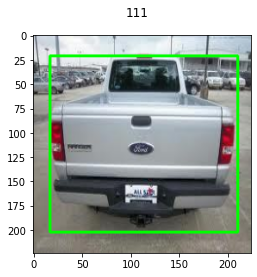

In [25]:
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd

#Pickup a random image number
img_num = np.random.randint(0, train_df.shape[0])
#Read the image and draw a rectangle as per bounding box information
img = cv2.imread(train_df.loc[img_num,'File'])
img = cv2.resize(img,(224, 224))
w = train_df.loc[img_num, 'Width']
h = train_df.loc[img_num, 'Height']
x_ratio = 224/w
y_ratio = 224/h
cv2.rectangle(img, 
             (int(train_df.loc[img_num, 'xmin']*x_ratio),int(train_df.loc[img_num, 'ymin']*y_ratio)),
             (int(train_df.loc[img_num, 'xmax']*x_ratio),int(train_df.loc[img_num, 'ymax']*y_ratio)), 
             (0,255,0),
             2)

#Convert BGR format (used by opencv to RGB format used by matplotlib)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#Draw image using matplotlib
plt.suptitle(train_df.loc[img_num, 'Class'])
plt.imshow(img)
plt.show()

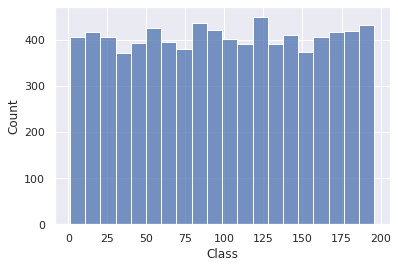

In [26]:
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.histplot(x= train_df['Class'],bins = 20)
# # From above histogram it is clear that we have almost equal density distribution among car classes in training data df

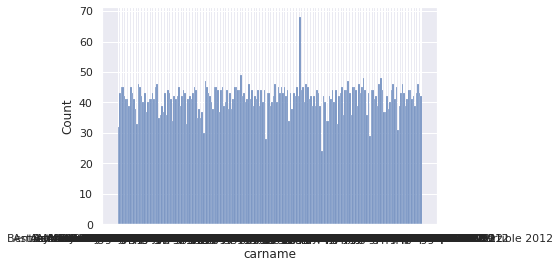

In [27]:
sns.histplot(train_df['carname'])

In [28]:
img_size = 224

In [29]:
num_classes=train_df['Label'].unique()
len(num_classes)

196

In [30]:
num_classes_test=test_df['Label'].unique()
len(num_classes_test)

196

In [31]:
def preprocess(df, batch_size=32):

    while True:

        #Create indexes
        image_nums = np.random.randint(0,df.shape[0], size=batch_size)

        #Create empty arrays to hold image input
        batch_images = np.zeros(shape=(batch_size, img_size, img_size, 3))

        #Classification Labels 
        batch_labels = np.zeros(shape=(batch_size, len(num_classes)))
        
        #Regression labels - 4 numbers per example image
        batch_bboxes = np.zeros(shape=(batch_size, 4))
        

        for i in range(batch_size):

            #Read image and resize
            img = tf.keras.preprocessing.image.load_img(df.loc[image_nums[i], 'File'], 
                                                        target_size=(img_size, img_size))
            
            #Conver to numpy array
            img_array = tf.keras.preprocessing.image.img_to_array(img)

            #Update batch
            batch_images[i] = img_array

            #Read image classification label & convert to one hot vector
            cl_label = df.loc[image_nums[i], 'Label']
            cl_label = tf.keras.utils.to_categorical(cl_label, num_classes=len(num_classes))
            batch_labels[i] = cl_label

            #Read and resize bounding box co-ordinates
            img_width = df.loc[image_nums[i], 'Width']
            img_height = df.loc[image_nums[i], 'Height']
            
            xmin = df.loc[image_nums[i], 'xmin'] * img_size/img_width
            xmax = df.loc[image_nums[i], 'xmax'] * img_size/img_width

            ymin = df.loc[image_nums[i], 'ymin'] * img_size/img_height
            ymax = df.loc[image_nums[i], 'ymax'] * img_size/img_height

            #We will ask model to predict xmin, ymin, width and height of bounding box
            batch_bboxes[i] = [xmin, ymin, xmax-xmin, ymax-ymin]

        #Normalize batch images as per Pre-trained model to be used
        for i in range(batch_size):
            batch_images[i] = tf.keras.applications.resnet50.preprocess_input(batch_images[i])
        
        #Make bounding boxes (x, y, w, h) as numbers between 0 and 1 - this seems to work better
        batch_bboxes = batch_bboxes/img_size

        #Return batch - use yield function to make it a python generator
        yield batch_images, [batch_labels, batch_bboxes]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 224, 224, 3)
(2, 196) (2, 4)
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

<Figure size 720x288 with 0 Axes>

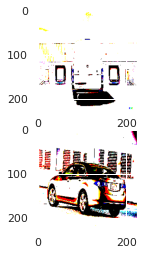

In [32]:
gen = preprocess(train_df, batch_size=2)
X, y = next(gen)
print(X.shape)
print(y[0].shape, y[1].shape)
print(y)

from keras.utils.np_utils import to_categorical

ll1111 = []
# label_encoder.inverse_transform(y[0][0])
for i in range(0,len(y[0])):
  y1 = int(np.argmax(y[0][i], axis=-1))
  ll1111.extend([y1])

print(len(ll1111))
print(le.inverse_transform(ll1111))

plt.figure(figsize =(10, 4))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(y[0]),1) 

for i in range(0,len(y[0])):
  axarr[i].imshow(X[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(2, 224, 224, 3)
(2, 196) (2, 4)
[array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
     

<Figure size 720x288 with 0 Axes>

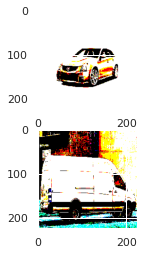

In [33]:
gen = preprocess(test_df, batch_size=2)
X, y = next(gen)
print(X.shape)
print(y[0].shape, y[1].shape)
print(y)

from keras.utils.np_utils import to_categorical

ll1111 = []
# label_encoder.inverse_transform(y[0][0])
for i in range(0,len(y[0])):
  y1 = int(np.argmax(y[0][i], axis=-1))
  ll1111.extend([y1])

print(len(ll1111))
print(le.inverse_transform(ll1111))

plt.figure(figsize =(10, 4))

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(len(y[0]),1) 

for i in range(0,len(y[0])):
  axarr[i].imshow(X[i])

In [34]:
tf.keras.backend.clear_session()
model = tf.keras.applications.efficientnet.EfficientNetB5(include_top=False, #Do not include FC layer at the end
                                       input_shape=(224, 224, 3),
                                       weights='imagenet')

115277824/115263384 [==============================] - 1s 0us/step


In [35]:
model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [36]:
# for layer in model.layers:
#     layer.trainable = True

# # # #Set pre-trained model layers to not trainable
for layer in model.layers:
    layer.trainable = True
#######Unfreezing all layers after layer#
for layer in model.layers[0:257]:
    layer.trainable = False
    # print(layer)

In [37]:
#get Output layer of Pre-trained model
x1 = model.output

#Flatten the output to feed to Dense layer
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)

#Add one Dense layer
x3 = tf.keras.layers.Dense(2048, activation='relu')(x2)

#Batch Norm
x5 = tf.keras.layers.BatchNormalization()(x3)

In [38]:
#Classification
label_output = tf.keras.layers.Dense(len(num_classes), 
                                     activation='softmax', 
                                     name='class_op')(x5)

In [39]:
#Regression
bbox_output = tf.keras.layers.Dense(4, 
                                    activation='sigmoid', 
                                    name='reg_op')(x5)

In [40]:
#Non Sequential model as it has two different outputs
final_model = tf.keras.models.Model(inputs=model.input, #Pre-trained model input as input layer
                                    outputs=[label_output,bbox_output]) #Output layer added

In [41]:
def calculate_iou(y_true, y_pred):
    
    
    """
    Input:
    Keras provides the input as numpy arrays with shape (batch_size, num_columns).
    
    Arguments:
    y_true -- first box, numpy array with format [x, y, width, height, conf_score]
    y_pred -- second box, numpy array with format [x, y, width, height, conf_score]
    x any y are the coordinates of the top left corner of each box.
    
    Output: IoU of type float32. (This is a ratio. Max is 1. Min is 0.)
    
    """

    
    results = []
    
    for i in range(0,y_true.shape[0]):
    
        # set the types so we are sure what type we are using
        y_true = np.array(y_true, dtype=np.float32)
        y_pred = np.array(y_pred, dtype=np.float32)

        #print(y_true.shape)
        #print(y_pred.shape)
        # boxTrue
        x_boxTrue_tleft = y_true[i,0]  # numpy index selection
        y_boxTrue_tleft = y_true[i,1]
        boxTrue_width = y_true[i,2]
        boxTrue_height = y_true[i,3]
        area_boxTrue = (boxTrue_width * boxTrue_height)

        # boxPred
        x_boxPred_tleft = y_pred[i,0]
        y_boxPred_tleft = y_pred[i,1]
        boxPred_width = y_pred[i,2]
        boxPred_height = y_pred[i,3]
        area_boxPred = (boxPred_width * boxPred_height)

        # calculate the bottom right coordinates for boxTrue and boxPred

        # boxTrue
        x_boxTrue_br = x_boxTrue_tleft + boxTrue_width
        y_boxTrue_br = y_boxTrue_tleft + boxTrue_height # Version 2 revision

        # boxPred
        x_boxPred_br = x_boxPred_tleft + boxPred_width
        y_boxPred_br = y_boxPred_tleft + boxPred_height # Version 2 revision


        # calculate the top left and bottom right coordinates for the intersection box, boxInt

        # boxInt - top left coords
        x_boxInt_tleft = np.max([x_boxTrue_tleft,x_boxPred_tleft])
        y_boxInt_tleft = np.max([y_boxTrue_tleft,y_boxPred_tleft]) # Version 2 revision

        # boxInt - bottom right coords
        x_boxInt_br = np.min([x_boxTrue_br,x_boxPred_br])
        y_boxInt_br = np.min([y_boxTrue_br,y_boxPred_br]) 

        # Calculate the area of boxInt, i.e. the area of the intersection 
        # between boxTrue and boxPred.
        # The np.max() function forces the intersection area to 0 if the boxes don't overlap.
        
        
        # Version 2 revision
        area_of_intersection = \
        np.max([0,(x_boxInt_br - x_boxInt_tleft)]) * np.max([0,(y_boxInt_br - y_boxInt_tleft)])

        iou = area_of_intersection / ((area_boxTrue + area_boxPred) - area_of_intersection)


        # This must match the type used in py_func
        iou = np.array(iou, dtype=np.float32)
        
        # append the result to a list at the end of each loop
        results.append(iou)
    
    # return the mean IoU score for the batch
    return np.mean(results)



def IoU(y_true, y_pred):
    
    # Note: the type float32 is very important. It must be the same type as the output from
    # the python function above or you too may spend many late night hours 
    # trying to debug and almost give up.
    
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)

    return iou

In [42]:
#Create train and test generator
batchsize = 40
train_generator = preprocess(train_df, batch_size=batchsize) #batchsize can be changed
test_generator = preprocess(test_df, batch_size=batchsize)

In [43]:
optimizerVar = tf.keras.optimizers.Adam(lr=0.0001)
final_model.compile(optimizer=optimizerVar, 
                    loss={'reg_op':'mse', 'class_op':'categorical_crossentropy'},
                    metrics={'reg_op':[IoU], 'class_op':['accuracy']})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
batchsize=40
final_model.fit(train_generator,
                epochs=10,
                initial_epoch=5,
                steps_per_epoch= train_df.shape[0]//batchsize,validation_data=test_generator,
                validation_steps = test_df.shape[0]//batchsize)

Epoch 6/10
203/203 [==============================] - 3617s 18s/step - loss: 4.3020 - class_op_loss: 4.1621 - reg_op_loss: 0.1399 - class_op_accuracy: 0.2379 - reg_op_IoU: 0.1573 - val_loss: 4.3854 - val_class_op_loss: 4.3081 - val_reg_op_loss: 0.0773 - val_class_op_accuracy: 0.1826 - val_reg_op_IoU: 0.3092
Epoch 7/10
203/203 [==============================] - 1450s 7s/step - loss: 1.7212 - class_op_loss: 1.6269 - reg_op_loss: 0.0943 - class_op_accuracy: 0.6734 - reg_op_IoU: 0.2394 - val_loss: 2.8941 - val_class_op_loss: 2.8316 - val_reg_op_loss: 0.0625 - val_class_op_accuracy: 0.3811 - val_reg_op_IoU: 0.3422
Epoch 8/10
203/203 [==============================] - 629s 3s/step - loss: 0.7536 - class_op_loss: 0.6922 - reg_op_loss: 0.0614 - class_op_accuracy: 0.8649 - reg_op_IoU: 0.3346 - val_loss: 2.2474 - val_class_op_loss: 2.2012 - val_reg_op_loss: 0.0462 - val_class_op_accuracy: 0.4709 - val_reg_op_IoU: 0.3912
Epoch 9/10
203/203 [==============================] - 357s 2s/step - loss: 0

In [45]:
final_model.save(EDIT_PATH + 'Models/Efficientnet.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [46]:
num_classes_test = test_df['Label'].unique()
label_class_dict = dict(zip(test_df['Label'], test_df['carname']))
print(len(num_classes_test))

196


In [47]:
def predict_and_draw(image_num, df):

    #Load image
    img = tf.keras.preprocessing.image.load_img(df.loc[image_num, 'File'])
    w, h = img.size

    #Prepare input for model
    #1. Resize image
    img_resized = img.resize((img_size, img_size))
    #2. Conver to array and make it a batch of 1
    input_array = tf.keras.preprocessing.image.img_to_array(img_resized)
    input_array = np.expand_dims(input_array, axis=0)

    #3. Normalize image data
    input_array = tf.keras.applications.resnet50.preprocess_input(input_array)

    #Prediction
    pred = final_model.predict(input_array)
    #Get classification and regression predictions
    label_pred, bbox_pred = pred[0][0], pred[1][0]
    #Get Label with highest probability
    pred_class = label_class_dict[np.argmax(label_pred)]

    #Read actual label and bounding box
    act_class = df.loc[image_num, 'Class']
    xmin, ymin, xmax, ymax = df.loc[image_num, ['xmin', 'ymin', 'xmax', 'ymax']]

    print('Real Label :', act_class, '\nPredicted Label: ', pred_class)
    
    #Draw bounding boxes - Actual (Red) and Predicted(Green)
    img = cv2.imread(df.loc[image_num, 'File'])
    
    #Draw actual bounding box - Red
    img = cv2.rectangle(img, (xmin, ymin), 
                        (xmax, ymax), (0,0,255), 3)
    
    #Draw predicted bounding box -  Green
    img = cv2.rectangle(img, (int(bbox_pred[0]*w), int(bbox_pred[1]*h)), 
                        (int((bbox_pred[0]+bbox_pred[2])*w), int((bbox_pred[1]+bbox_pred[3])*h)), (0,255,0), 3
                        )

    #Display the picture
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

Real Label : 61 
Predicted Label:  Lincoln Town Car Sedan 2011


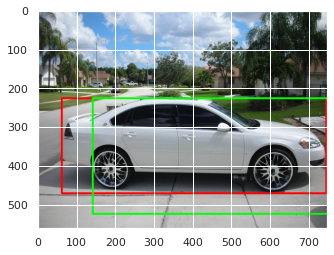

In [48]:
#Predict on Test Dataset
image_num = np.random.randint(0, test_df.shape[0])
predict_and_draw(image_num, test_df)

In [ ]:
from tensorflow.keras.models import load_model
new_model= load_model(EDIT_PATH + 'Models/Efficientnet.h5',custom_objects={'IoU': IoU})